In [80]:
from google.colab import files

In [81]:

import os
uploaded=files.upload()
import pandas as pd
train_df=pd.read_csv("tour_logs_train.csv")

Saving tour_logs_train.csv to tour_logs_train (2).csv


In [82]:
uploaded=files.upload()
test_df=pd.read_csv("tour_logs_test_input.csv")

Saving tour_logs_test_input.csv to tour_logs_test_input (2).csv


In [83]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# **DATA CLEANING**

In [84]:

class Cleaning:
    def __init__(self):
        #Standard words for time
        self.t_standard = {'Morning': 10, 'Afternoon': 14, 'Evening': 19, 'Late Night': 23}

    def _price_logic(self, x):
        #I AM CORRECTING THE PRICE
        if pd.isna(x):
            return np.nan
        x = str(x).strip().lower()
        if x == "free":
            return 0.0

         #checking if words like vip or usd are there
        for i in ["vip", "usd"]:
            x = x.replace(i, "").strip()

        try:
            if "£" in x:
                return float(x.replace("£", "")) * 1.34
            if "€" in x:
                return float(x.replace("€", "")) * 1.17
            if "$" in x:
                return float(x.replace("$", ""))

            return float(x)
        except ValueError:
            return np.nan

    def convert_price(self, df):
        df = df.copy()
        df["Ticket_Price"] = df["Ticket_Price"].apply(self._price_logic)
        return df

    def crowd_size(self, df):
        df = df.copy()
        return df[(df["Crowd_Size"] < 1500) & (df["Crowd_Size"] > 0)]

    def clean_energy(self, df):
        #Removes rows with impossible Crowd Energy
        df = df.copy()
        df["Crowd_Energy"]=df.loc[(df["Crowd_Energy"] <= 100) & (df["Crowd_Energy"] >= 0),"Crowd_Energy"]
        return df

    def volume_rect(self, df):
        #Replaces impossible volume levels
        df = df.copy()
        df.loc[(df["Volume_Level"] <1) | (df["Volume_Level"] > 11), "Volume_Level"] = np.nan
        return df

    def correct_time(self, df):
        #CREATING AN HOUR COLUMMN
        df = df.copy()

        def get_hour(x):
            try:
                return pd.to_datetime(x, format='mixed').hour
            except:
                return self.t_standard.get(x, 20) # Default to 20 (8pm)
            #t_standard was in our constructor above
        df["Hour"] = df["Show_DateTime"].apply(get_hour)
        return df
    def price_outlier(self,df):
        df=df.copy()
        df["Ticket_Price"]=df.loc[(df["Ticket_Price"]<=150) & (df["Ticket_Price"]>=0),"Ticket_Price"]
        return df
cleaner =Cleaning()

# 2. APPLYING EVERYTHING TO THE TRAINING DATA BY PASSING TRAIN_DF TO THE OBJECT
train_df = cleaner.clean_energy(train_df)
train_df = cleaner.crowd_size(train_df)
train_df = cleaner.convert_price(train_df)
train_df = cleaner.volume_rect(train_df)
train_df = cleaner.correct_time(train_df)
train_df=cleaner.price_outlier(train_df)
#SAME WITH TESTING DATA
test_df = cleaner.volume_rect(test_df)
test_df = cleaner.correct_time(test_df)
test_df=cleaner.convert_price(test_df)
test_df=cleaner.price_outlier(test_df)
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)
print("Null Prices in Train:", train_df["Ticket_Price"].isna().sum())
print("Train Head:")
print(train_df[["Ticket_Price", "Volume_Level", "Hour", "Crowd_Energy"]].head())



Train Shape: (1950, 14)
Test Shape: (500, 13)
Null Prices in Train: 44
Train Head:
   Ticket_Price  Volume_Level  Hour  Crowd_Energy
0         52.93           5.0    21         64.96
1         66.33           2.0    22         66.42
2         51.37           1.0    15         42.58
3         64.77          10.0     8          0.00
4         47.34           8.0    17         67.55


# **EXPLORATORY DATA ANALYSIS WITH THE TRAINING DATA**

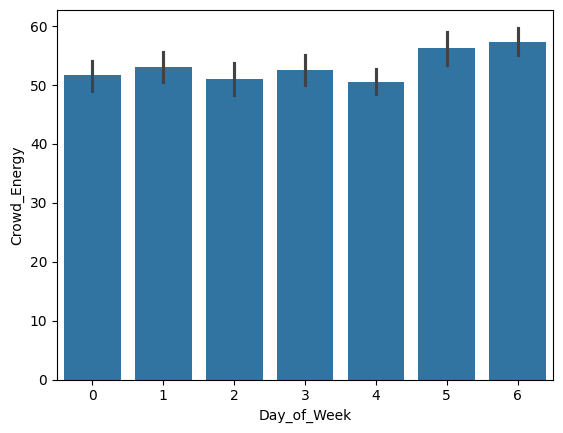

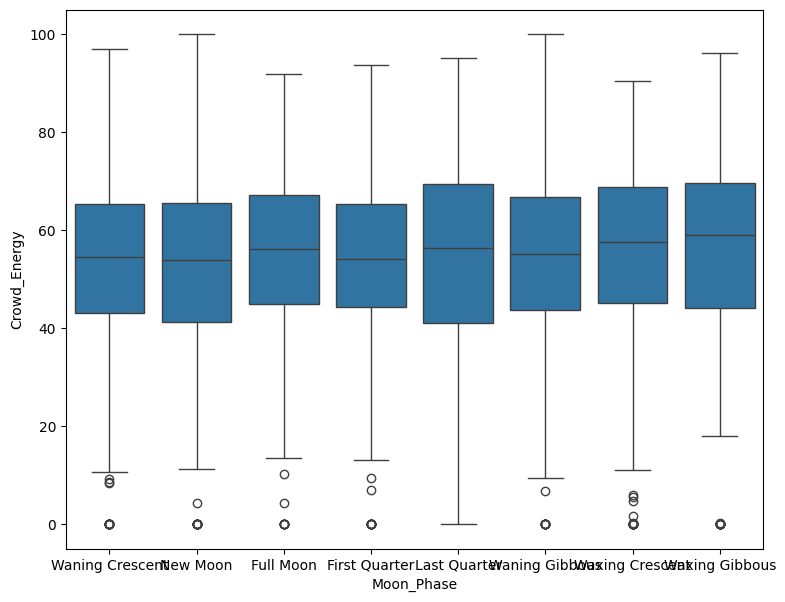

In [85]:

plt.show()
sns.barplot(data=train_df,x=train_df["Day_of_Week"],y=train_df["Crowd_Energy"])
plt.show()
plt.figure(figsize=(9,7))
sns.boxplot(data=train_df,x=train_df["Moon_Phase"],y=train_df["Crowd_Energy"])
plt.show()

In [ ]:
#THIS SHOWS THAT FULL MOON HAS NO SPECIAL EFFECT AND THE SINGER'S THINKING WAS NOT CORRECT AND ALSO ITS A USELESS FEATURE AS THE
#MOON PHASE HAS NO RELATIONSHIP WITH ENERGY SO WE  CAN DROP IT

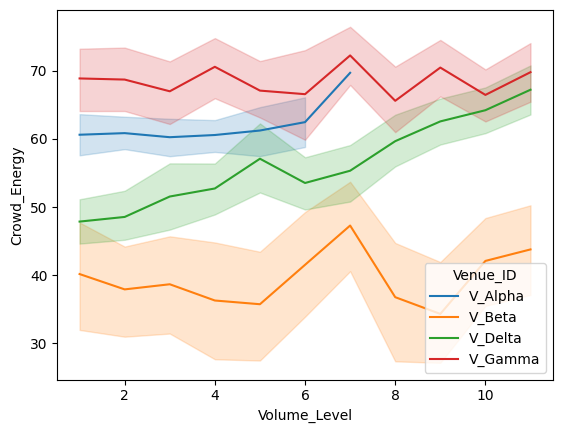

In [86]:
sns.lineplot(
    x=train_df["Volume_Level"],
    y=train_df["Crowd_Energy"],
    hue=train_df["Venue_ID"]
)
plt.show()

**ONE THING WE CAN CLEARLY SEE IS THAT CROWD V ALPHA DOESNT LIKE LOUD SOUND AS AFTER 7 VOLUME LEVEL THEIR GRAPH DISAPPEARS AND ALSO V DELTA HAS LOUDER BETTER AS THE SINGER SAID**

<Axes: xlabel='Hour', ylabel='Crowd_Energy'>

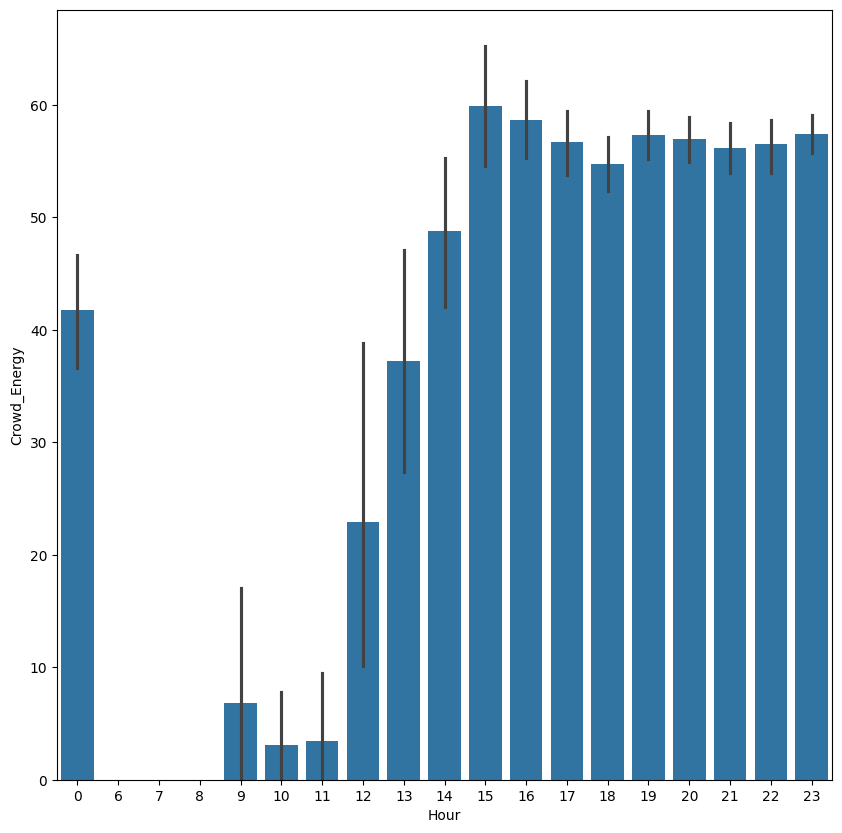

In [87]:
plt.figure(figsize=(10,10))
sns.barplot(data=train_df,x="Hour",y="Crowd_Energy")


This justifies that all our relationships are not linear and we cannot use linear regression crowd energy increases by after noon then decreases in evening and then again increases in night

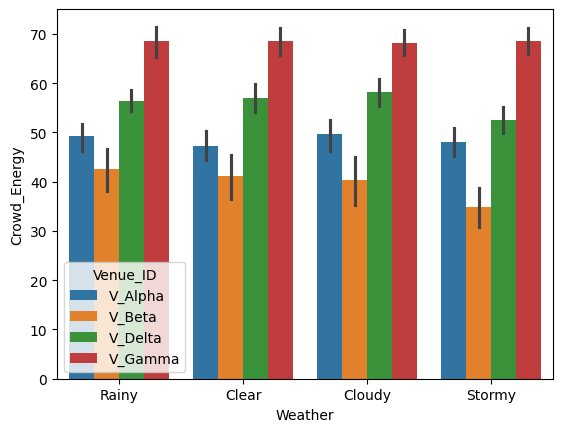

In [88]:
sns.barplot(data=train_df,x="Weather",y="Crowd_Energy",hue="Venue_ID")
plt.show()

**THIS SHOWS THAT SINGER WAS CORRECT THAT V DELTA  HAS EFFECT OF STORM AS ITS PARTLY OPEN,ALSO STORM AFFECTS V BETA**

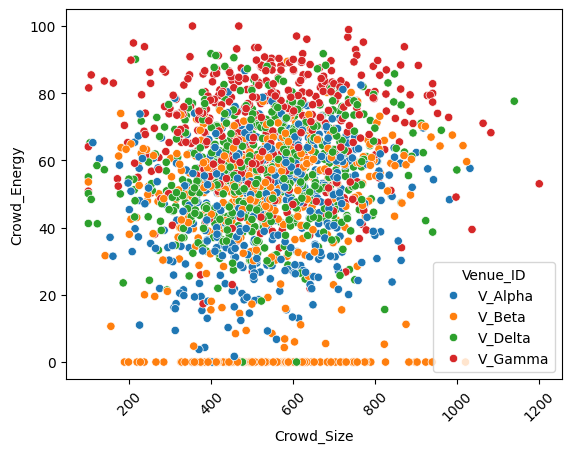

In [89]:


sns.scatterplot(
    data=train_df,
    x="Crowd_Size",
    y="Crowd_Energy",
    hue="Venue_ID"
)

plt.xticks(rotation=45)
plt.show()


NO PROPER RELATION IN CROWD SIZE AND ENERGY . V GAMMA ALWAYS HAS HIGH ENERGY AND V BETA HAS ALWAYS 0 ENERGY BEFORE 12PM AS THE SINGER SAID THEYA RE GOTHIC

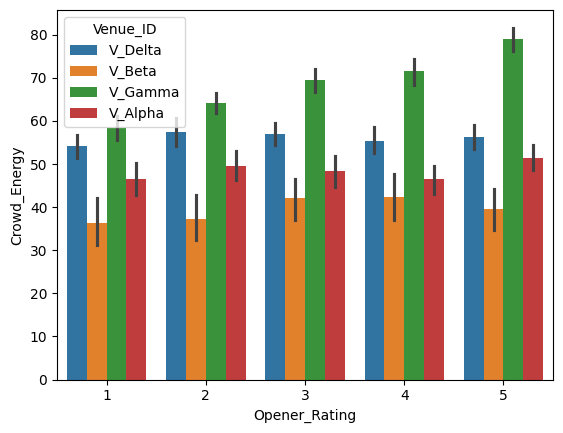

In [90]:
sns.barplot(data=train_df,x="Opener_Rating",y="Crowd_Energy",hue="Venue_ID")
plt.show()
#V gamma is getting much effected by the opener rating the singer was true

V GAMMA IS GETTING EFFECTED BY RATING BUT OTHERS NOT SO SINGER IIS CORRECT

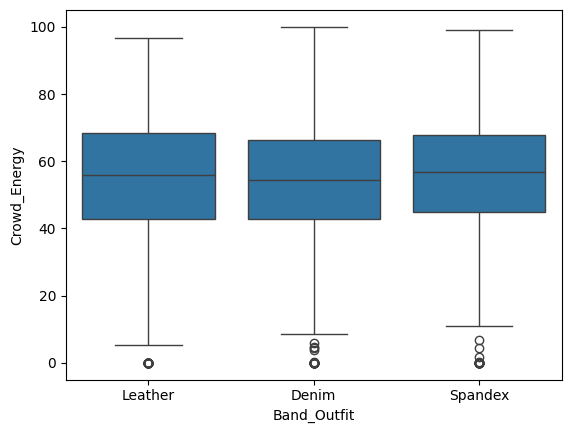

In [91]:
sns.boxplot(data=train_df,x="Band_Outfit",y="Crowd_Energy")
plt.show()


USELESS FEATURE I THINK, IT MUST BE DROPPED

##**feature engineering ,column dropping**

In [92]:
#MAKING WEEKEND WEEKDAYS COLUMN
def feature_engineering(df):
        df = df.copy()
        df['Is_Weekend'] = df['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)
        return df
def drop_unnecessary(df):
        #DROPPING NOICE AND DATA LEAKAGE COLUMNS
        df = df.copy()
        df=df.drop(columns=["Gig_ID","Show_DateTime","Merch_Sales_Post_Show","Moon_Phase","Band_Outfit","Day_of_Week"])
        return df
train_df=feature_engineering(train_df)
test_df=feature_engineering(test_df)
train_df=drop_unnecessary(train_df)
test_df=drop_unnecessary(test_df)
train_df = train_df[~train_df["Crowd_Energy"].isna()]
train_df.head()
train_df["Volume_Level"].mean()

np.float64(5.689020771513353)

In [93]:
train_df.isna().sum()

,0
Venue_ID,0
Volume_Level,257
Ticket_Price,44
Crowd_Size,0
Opener_Rating,0
Weather,0
Crowd_Energy,0
Hour,0
Is_Weekend,0


## **DATA PREPROCESSING**

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import SimpleImputer
xtest=test_df
ytrain=train_df["Crowd_Energy"]
xtrain=train_df.drop(columns=["Crowd_Energy"])

xtrain["Volume_Level"]=xtrain["Volume_Level"].fillna(6)
xtest["Volume_Level"]= xtest["Volume_Level"].fillna(6)
#filling volume by nearest integer to mean

imputer = SimpleImputer(strategy='mean')
cols_to_fix = ['Ticket_Price', 'Crowd_Size']
xtrain[cols_to_fix] = imputer.fit_transform(xtrain[cols_to_fix])
xtest[cols_to_fix] = imputer.transform(xtest[cols_to_fix])


from sklearn.preprocessing import OneHotEncoder
categorical_cols = ['Venue_ID','Weather']

c=ColumnTransformer(transformers=[("encoder",OneHotEncoder(handle_unknown='ignore'),categorical_cols)],remainder='passthrough')
xtrain=c.fit_transform(xtrain)
xtest=c.transform(xtest)

# TRAINING

In [95]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=250, max_depth=9, random_state=42,min_samples_split=20,max_features=8)
print("Training model...in progress guys!!!")
model.fit(xtrain, ytrain)

print("Generated the predictions...")
predictions = model.predict(xtest)
final_predictions = np.clip(predictions, 0, 100)

Training model...in progress guys!!!
Generated the predictions...


# **validating our model using k fold cross validation**

In [96]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    model,
    xtrain,
    ytrain,
    cv=kfold,
    scoring='neg_root_mean_squared_error'
)

rmse_scores = -cv_scores

print(f"Scores for each fold: {rmse_scores}")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Standard Deviation: {np.std(rmse_scores):.4f}")

Scores for each fold: [13.48896244 13.5850228  12.86972605 12.97652635 13.29291932]
Average RMSE: 13.2426
Standard Deviation: 0.2794


# **FINAL SUBMISSION**

In [97]:
original_test_df = pd.read_csv("tour_logs_test_input.csv")

submission = pd.DataFrame({
    'Gig_ID': original_test_df['Gig_ID'],
    'Crowd_Energy': predictions
})
submission.to_csv('predictions.csv', index=False)
print("Done! Saved to final_submission.csv")
from google.colab import files
files.download("predictions.csv")

Done! Saved to final_submission.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>